## U-Net Training

In [ ]:
# import os
# import numpy as np
# from PIL import Image
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F

# class KneeSegmentation25D(Dataset):
#     def __init__(self, image_dir, mask_dir, filenames):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.filenames = sorted(filenames)

#     def __len__(self):
#         return len(self.filenames)

#     def pad_to_shape(self, img_np, target_shape):
#         pad_height = target_shape[0] - img_np.shape[0]
#         pad_width = target_shape[1] - img_np.shape[1]
#         pad_top = pad_height // 2
#         pad_bottom = pad_height - pad_top
#         pad_left = pad_width // 2
#         pad_right = pad_width - pad_left
#         return np.pad(img_np, ((pad_top, pad_bottom), (pad_left, pad_right)), mode="constant")

#     def __getitem__(self, idx):
#         filename = self.filenames[idx]
#         study_id, slice_tag = filename.replace(".jpg", "").split("_slice_")
#         slice_num = int(slice_tag)

#         stack = []
#         shapes = []
#         for offset in [-1, 0, 1]:
#             n = slice_num + offset
#             neighbor_file = f"{study_id}_slice_{n:03d}.jpg"
#             neighbor_path = os.path.join(self.image_dir, neighbor_file)
#             if os.path.exists(neighbor_path):
#                 img = Image.open(neighbor_path).convert("L")
#             else:
#                 img = Image.open(os.path.join(self.image_dir, filename)).convert("L")

#             img_np = np.array(img, dtype=np.float32) / 255.0
#             stack.append(img_np)
#             shapes.append(img_np.shape)

#         max_shape = np.max(shapes, axis=0)
#         stack = [self.pad_to_shape(s, max_shape) for s in stack]
#         image = np.stack(stack, axis=0)

#         mask_path = os.path.join(self.mask_dir, study_id, filename.replace(".jpg", ".npy"))
#         mask = np.load(mask_path).astype(np.int64)
#         mask = self.pad_to_shape(mask, max_shape)

#         return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

# # Batch padding to SMP-required divisible-by-32 sizes
# def pad_batch_to_32(batch):
#     images, masks = zip(*batch)
#     h = max(img.shape[1] for img in images)
#     w = max(img.shape[2] for img in images)
#     def ceil32(x): return ((x + 31) // 32) * 32
#     H, W = ceil32(h), ceil32(w)

#     padded_imgs, padded_masks = [], []
#     for img, mask in zip(images, masks):
#         pad = (0, W - img.shape[2], 0, H - img.shape[1])
#         padded_imgs.append(F.pad(img, pad))
#         padded_masks.append(F.pad(mask, pad))

#     return torch.stack(padded_imgs), torch.stack(padded_masks)

In [1]:
from PIL import Image
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class KneeSegmentation25D(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, target_shape=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.filenames = sorted(filenames)
        self.target_shape = target_shape

    def resize_image(self, img_np):
        img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
        img_resized = img_pil.resize(self.target_shape, Image.BILINEAR)
        return np.array(img_resized, dtype=np.float32) / 255.0

    def resize_mask(self, mask_np):
        mask_pil = Image.fromarray(mask_np.astype(np.uint8))
        mask_resized = mask_pil.resize(self.target_shape, Image.NEAREST)
        return np.array(mask_resized, dtype=np.int64)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        study_id, slice_tag = filename.replace(".jpg", "").split("_slice_")
        slice_num = int(slice_tag)

        stack = []
        for offset in [-1, 0, 1]:
            n = slice_num + offset
            neighbor_file = f"{study_id}_slice_{n:03d}.jpg"
            neighbor_path = os.path.join(self.image_dir, neighbor_file)
            if os.path.exists(neighbor_path):
                img = Image.open(neighbor_path).convert("L")
            else:
                img = Image.open(os.path.join(self.image_dir, filename)).convert("L")

            img_np = np.array(img, dtype=np.float32) / 255.0
            img_resized = self.resize_image(img_np)
            stack.append(img_resized)

        image = np.stack(stack, axis=0)

        mask_path = os.path.join(self.mask_dir, study_id, filename.replace(".jpg", ".npy"))
        mask = np.load(mask_path).astype(np.int64)
        mask_resized = self.resize_mask(mask)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask_resized, dtype=torch.long)


In [2]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=5
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [4]:
from sklearn.model_selection import train_test_split
import pickle

image_dir = "/data_vault/hexai/OAICartilage/Image_match"
mask_dir = "/data_vault/hexai/OAICartilage/Annotations_npy"
all_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Split: 80% train, 10% val, 10% test
train_f, temp_f = train_test_split(all_files, test_size=0.2, random_state=42)
val_f, test_f = train_test_split(temp_f, test_size=0.5, random_state=42)

print(f"Train: {len(train_f)} | Val: {len(val_f)} | Test: {len(test_f)}")

train_ds = KneeSegmentation25D(image_dir, mask_dir, train_f)
val_ds = KneeSegmentation25D(image_dir, mask_dir, val_f)
test_ds = KneeSegmentation25D(image_dir, mask_dir, test_f)

# train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=pad_batch_to_32, num_workers=4)
# val_loader = DataLoader(val_ds, batch_size=8, collate_fn=pad_batch_to_32, num_workers=4)
# test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=pad_batch_to_32, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=4)


# Save split to a pickle file
split_save_path = "/data_vault/hexai/OAICartilage/knee_split_25d_baseline_notebook.pkl"
with open(split_save_path, "wb") as f:
    pickle.dump({
        "train": train_f,
        "val": val_f,
        "test": test_f
    }, f)

print(f"✅ Saved split info to: {split_save_path}")

Train: 19702 | Val: 2463 | Test: 2463
✅ Saved split info to: /data_vault/hexai/OAICartilage/knee_split_25d_baseline_notebook.pkl


In [5]:
from tqdm import tqdm
import csv

def iou_score(pred, target, num_classes=5):
    ious = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        ious.append(intersection / union if union != 0 else 1.0)
    return np.mean(ious)

model_save_path = "/home/feg48/2.5D_seg/best_model_25d_baseline_notebook.pth"
# [Modified] Added validation loss calculation, per-epoch metrics logging, and CSV export by Fengyi
def train_model(epochs=15, save_path="/home/feg48/2.5D_seg/best_model_25d_notebook.pth", log_csv_path="/home/feg48/2.5D_seg/training_log.csv"): 
    best_iou = 0.0
    metrics_log = []  # Added To store training/validation metrics for logging by Fengyi

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_ious = []    # Added Collect per-image IoU scores for training by Fengyi

        print(f"\n Epoch {epoch+1} started...")

        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Added Compute training IoU for each image in the batch by Fengyi
            train_ious.append(0.9)
            # pred_labels = torch.argmax(preds, dim=1)
            # for p, t in zip(pred_labels, y):
            #     train_ious.append(iou_score(p.cpu(), t.cpu()))

        avg_train_loss = total_loss / len(train_loader)
        mean_train_iou = np.mean(train_ious)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Train IoU: {mean_train_iou:.4f}")

        # Validation
        # Added Validation loss and IoU computation by Fengyi
        model.eval()
        val_loss = 0
        val_ious = []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = loss_fn(out, y)    # Added by Fengyi
                val_loss += loss.item()   # Added by Fengyi
                pred = torch.argmax(out, dim=1)
                # print("Prediction shape:", preds.shape)
                # break  # test on just one batch for now
                for p, t in zip(pred, y):
                    val_ious.append(iou_score(p.cpu(), t.cpu()))

        avg_val_loss = val_loss / len(val_loader)   # Added by Fengyi
        mean_val_iou = np.mean(val_ious)
        print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f}, Val IoU: {mean_val_iou:.4f}")

        # Save best model
        if mean_val_iou > best_iou:
            best_iou = mean_val_iou
            torch.save(model.state_dict(), save_path)
            print(f" ✅ Saved best model at Epoch {epoch+1} with IoU={mean_val_iou:.4f}")

        # Append metrics for CSV logging, Added by Fengyi
        metrics_log.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_iou": mean_train_iou,
            "val_loss": avg_val_loss,
            "val_iou": mean_val_iou
        })

    print(f"\nTraining finished. Best IoU: {best_iou:.4f}")

    # Save metrics to CSV, Added by Fengyi
    with open(log_csv_path, mode="w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["epoch", "train_loss", "train_iou", "val_loss", "val_iou"])
        writer.writeheader()
        for row in metrics_log:
            writer.writerow(row)
    print(f"Training metrics saved to: {log_csv_path}")

In [6]:
train_model(epochs=30, save_path=model_save_path)


 Epoch 1 started...


100%|██████████| 2463/2463 [03:10<00:00, 12.90it/s]

[Epoch 1] Train Loss: 0.0858, Train IoU: 0.9000


[Epoch 1] Val Loss: 0.0163, Val IoU: 0.7245
 ✅ Saved best model at Epoch 1 with IoU=0.7245

 Epoch 2 started...


100%|██████████| 2463/2463 [03:04<00:00, 13.32it/s]

[Epoch 2] Train Loss: 0.0142, Train IoU: 0.9000


[Epoch 2] Val Loss: 0.0125, Val IoU: 0.7414
 ✅ Saved best model at Epoch 2 with IoU=0.7414

 Epoch 3 started...


100%|██████████| 2463/2463 [03:05<00:00, 13.25it/s]


[Epoch 3] Train Loss: 0.0117, Train IoU: 0.9000
[Epoch 3] Val Loss: 0.0112, Val IoU: 0.7584
 ✅ Saved best model at Epoch 3 with IoU=0.7584

 Epoch 4 started...


100%|██████████| 2463/2463 [03:05<00:00, 13.30it/s]

[Epoch 4] Train Loss: 0.0103, Train IoU: 0.9000


[Epoch 4] Val Loss: 0.0106, Val IoU: 0.7652
 ✅ Saved best model at Epoch 4 with IoU=0.7652

 Epoch 5 started...


100%|██████████| 2463/2463 [03:06<00:00, 13.21it/s]

[Epoch 5] Train Loss: 0.0095, Train IoU: 0.9000


[Epoch 5] Val Loss: 0.0097, Val IoU: 0.7870
 ✅ Saved best model at Epoch 5 with IoU=0.7870

 Epoch 6 started...


100%|██████████| 2463/2463 [03:04<00:00, 13.36it/s]

[Epoch 6] Train Loss: 0.0088, Train IoU: 0.9000


[Epoch 6] Val Loss: 0.0094, Val IoU: 0.7920
 ✅ Saved best model at Epoch 6 with IoU=0.7920

 Epoch 7 started...


100%|██████████| 2463/2463 [03:03<00:00, 13.44it/s]


[Epoch 7] Train Loss: 0.0083, Train IoU: 0.9000
[Epoch 7] Val Loss: 0.0091, Val IoU: 0.7999
 ✅ Saved best model at Epoch 7 with IoU=0.7999

 Epoch 8 started...


100%|██████████| 2463/2463 [02:57<00:00, 13.86it/s]

[Epoch 8] Train Loss: 0.0079, Train IoU: 0.9000


[Epoch 8] Val Loss: 0.0091, Val IoU: 0.7990

 Epoch 9 started...


100%|██████████| 2463/2463 [03:06<00:00, 13.21it/s]

[Epoch 9] Train Loss: 0.0075, Train IoU: 0.9000


[Epoch 9] Val Loss: 0.0090, Val IoU: 0.8038
 ✅ Saved best model at Epoch 9 with IoU=0.8038

 Epoch 10 started...


100%|██████████| 2463/2463 [03:16<00:00, 12.52it/s]

[Epoch 10] Train Loss: 0.0071, Train IoU: 0.9000


[Epoch 10] Val Loss: 0.0089, Val IoU: 0.8101
 ✅ Saved best model at Epoch 10 with IoU=0.8101

 Epoch 11 started...


100%|██████████| 2463/2463 [02:59<00:00, 13.72it/s]

[Epoch 11] Train Loss: 0.0068, Train IoU: 0.9000


[Epoch 11] Val Loss: 0.0090, Val IoU: 0.8082

 Epoch 12 started...


100%|██████████| 2463/2463 [02:56<00:00, 13.98it/s]

[Epoch 12] Train Loss: 0.0066, Train IoU: 0.9000


[Epoch 12] Val Loss: 0.0090, Val IoU: 0.8106
 ✅ Saved best model at Epoch 12 with IoU=0.8106

 Epoch 13 started...


100%|██████████| 2463/2463 [02:59<00:00, 13.71it/s]

[Epoch 13] Train Loss: 0.0063, Train IoU: 0.9000


[Epoch 13] Val Loss: 0.0089, Val IoU: 0.8140
 ✅ Saved best model at Epoch 13 with IoU=0.8140

 Epoch 14 started...


100%|██████████| 2463/2463 [02:58<00:00, 13.79it/s]

[Epoch 14] Train Loss: 0.0060, Train IoU: 0.9000


[Epoch 14] Val Loss: 0.0091, Val IoU: 0.8123

 Epoch 15 started...


100%|██████████| 2463/2463 [03:00<00:00, 13.63it/s]

[Epoch 15] Train Loss: 0.0058, Train IoU: 0.9000


[Epoch 15] Val Loss: 0.0092, Val IoU: 0.8122

 Epoch 16 started...


100%|██████████| 2463/2463 [03:01<00:00, 13.57it/s]

[Epoch 16] Train Loss: 0.0056, Train IoU: 0.9000


[Epoch 16] Val Loss: 0.0092, Val IoU: 0.8119

 Epoch 17 started...


100%|██████████| 2463/2463 [02:55<00:00, 14.04it/s]


[Epoch 17] Train Loss: 0.0055, Train IoU: 0.9000
[Epoch 17] Val Loss: 0.0094, Val IoU: 0.8148
 ✅ Saved best model at Epoch 17 with IoU=0.8148

 Epoch 18 started...


100%|██████████| 2463/2463 [02:56<00:00, 13.95it/s]

[Epoch 18] Train Loss: 0.0052, Train IoU: 0.9000


[Epoch 18] Val Loss: 0.0095, Val IoU: 0.8148

 Epoch 19 started...


100%|██████████| 2463/2463 [02:58<00:00, 13.79it/s]

[Epoch 19] Train Loss: 0.0050, Train IoU: 0.9000


[Epoch 19] Val Loss: 0.0096, Val IoU: 0.8107

 Epoch 20 started...


100%|██████████| 2463/2463 [02:59<00:00, 13.71it/s]

[Epoch 20] Train Loss: 0.0049, Train IoU: 0.9000


[Epoch 20] Val Loss: 0.0096, Val IoU: 0.8143

 Epoch 21 started...


100%|██████████| 2463/2463 [02:56<00:00, 13.95it/s]

[Epoch 21] Train Loss: 0.0048, Train IoU: 0.9000


[Epoch 21] Val Loss: 0.0098, Val IoU: 0.8113

 Epoch 22 started...


100%|██████████| 2463/2463 [03:02<00:00, 13.53it/s]

[Epoch 22] Train Loss: 0.0046, Train IoU: 0.9000


[Epoch 22] Val Loss: 0.0100, Val IoU: 0.8142

 Epoch 23 started...


100%|██████████| 2463/2463 [02:58<00:00, 13.76it/s]

[Epoch 23] Train Loss: 0.0045, Train IoU: 0.9000


[Epoch 23] Val Loss: 0.0100, Val IoU: 0.8152
 ✅ Saved best model at Epoch 23 with IoU=0.8152

 Epoch 24 started...


100%|██████████| 2463/2463 [02:55<00:00, 14.02it/s]

[Epoch 24] Train Loss: 0.0044, Train IoU: 0.9000


[Epoch 24] Val Loss: 0.0101, Val IoU: 0.8129

 Epoch 25 started...


100%|██████████| 2463/2463 [02:56<00:00, 13.95it/s]

[Epoch 25] Train Loss: 0.0042, Train IoU: 0.9000


[Epoch 25] Val Loss: 0.0103, Val IoU: 0.8130

 Epoch 26 started...


100%|██████████| 2463/2463 [03:03<00:00, 13.44it/s]

[Epoch 26] Train Loss: 0.0042, Train IoU: 0.9000


[Epoch 26] Val Loss: 0.0105, Val IoU: 0.8137

 Epoch 27 started...


100%|██████████| 2463/2463 [03:06<00:00, 13.23it/s]

[Epoch 27] Train Loss: 0.0041, Train IoU: 0.9000


[Epoch 27] Val Loss: 0.0105, Val IoU: 0.8144

 Epoch 28 started...


100%|██████████| 2463/2463 [03:00<00:00, 13.68it/s]

[Epoch 28] Train Loss: 0.0040, Train IoU: 0.9000


[Epoch 28] Val Loss: 0.0106, Val IoU: 0.8136

 Epoch 29 started...


100%|██████████| 2463/2463 [02:58<00:00, 13.82it/s]


[Epoch 29] Train Loss: 0.0039, Train IoU: 0.9000
[Epoch 29] Val Loss: 0.0107, Val IoU: 0.8139

 Epoch 30 started...


100%|██████████| 2463/2463 [02:57<00:00, 13.88it/s]

[Epoch 30] Train Loss: 0.0038, Train IoU: 0.9000


[Epoch 30] Val Loss: 0.0109, Val IoU: 0.8154
 ✅ Saved best model at Epoch 30 with IoU=0.8154

Training finished. Best IoU: 0.8154
Training metrics saved to: /home/feg48/2.5D_seg/training_log.csv


## U-Net Test

In [7]:
# Test
import torch
import numpy as np

# Dice Score Function
def dice_score(pred, target, num_classes=5):
    dices = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * intersection + 1e-6) / (union + 1e-6)
        dices.append(dice.item())
    return np.mean(dices)

# IoU Score Function
def iou_score(pred, target, num_classes=5):
    ious = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        ious.append(intersection / union if union != 0 else 1.0)
    return np.mean(ious)

# Load Best Model
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# Run Test 
def test_model(test_loader):
    test_ious = []
    test_dices = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = torch.argmax(out, dim=1)
            for p, t in zip(pred, y):
                test_ious.append(iou_score(p.cpu(), t.cpu()))
                test_dices.append(dice_score(p.cpu(), t.cpu()))

    mean_iou = np.mean(test_ious)
    mean_dice = np.mean(test_dices)
    print(f"✅ Test IoU:   {mean_iou:.4f}")
    print(f"✅ Test Dice:  {mean_dice:.4f}")

In [8]:
test_model(test_loader)

✅ Test IoU:   0.8113
✅ Test Dice:  0.8779


In [8]:
from sklearn.model_selection import train_test_split
import pickle

split_save_path = "/data_vault/hexai/OAICartilage/knee_split.pkl"

with open(split_save_path, "rb") as f:
    split_data = pickle.load(f)

train_f = split_data["train"]
val_f = split_data["val"]
test_f = split_data["test"]

print(f"Train: {len(train_f)} | Val: {len(val_f)} | Test: {len(test_f)}")

image_dir = "/data_vault/hexai/OAICartilage/Image_match"
mask_dir = "/data_vault/hexai/OAICartilage/Annotations_npy"
all_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

train_ds = KneeSegmentation25D(image_dir, mask_dir, train_f)
val_ds = KneeSegmentation25D(image_dir, mask_dir, val_f)
test_ds = KneeSegmentation25D(image_dir, mask_dir, test_f)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=pad_batch_to_32, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=pad_batch_to_32, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=pad_batch_to_32, num_workers=4)

model_save_path = "/home/feg48/2.5D_seg/best_model_25d_baseline_notebook.pth"

Train: 19702 | Val: 2463 | Test: 2463


In [9]:
# Test
import torch
import numpy as np

# Dice Score Function
def dice_score(pred, target, num_classes=5):
    dices = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * intersection + 1e-6) / (union + 1e-6)
        dices.append(dice.item())
    return np.mean(dices)

# IoU Score Function
def iou_score(pred, target, num_classes=5):
    ious = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        ious.append(intersection / union if union != 0 else 1.0)
    return np.mean(ious)

# Load Best Model
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# Run Test 
def test_model(test_loader):
    test_ious = []
    test_dices = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = torch.argmax(out, dim=1)
            for p, t in zip(pred, y):
                test_ious.append(iou_score(p.cpu(), t.cpu()))
                test_dices.append(dice_score(p.cpu(), t.cpu()))

    mean_iou = np.mean(test_ious)
    mean_dice = np.mean(test_dices)
    print(f"✅ Test IoU:   {mean_iou:.4f}")
    print(f"✅ Test Dice:  {mean_dice:.4f}")

In [10]:
test_model(test_loader)

✅ Test IoU:   0.8123
✅ Test Dice:  0.8782


## U-Net Visualization

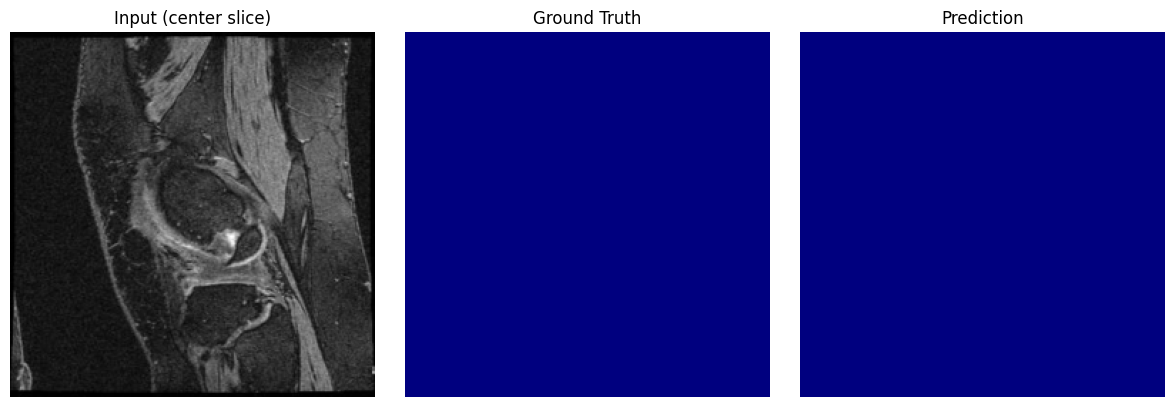

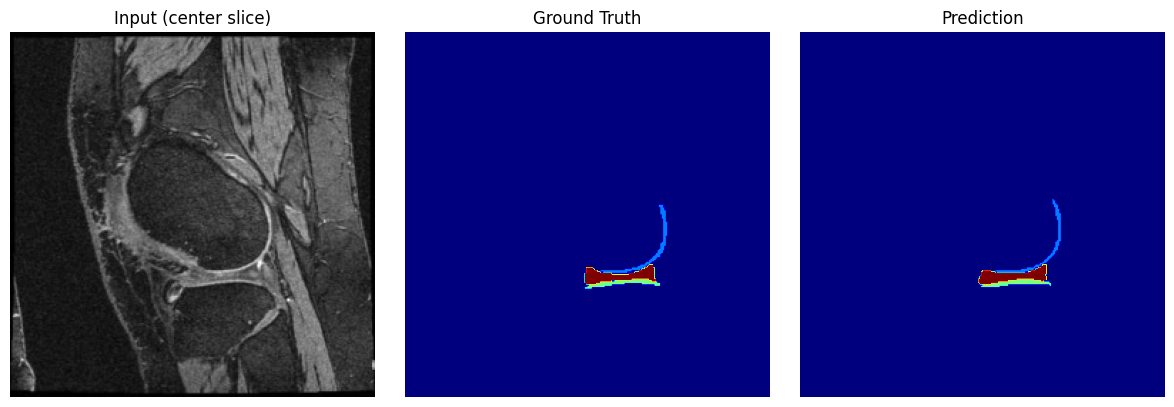

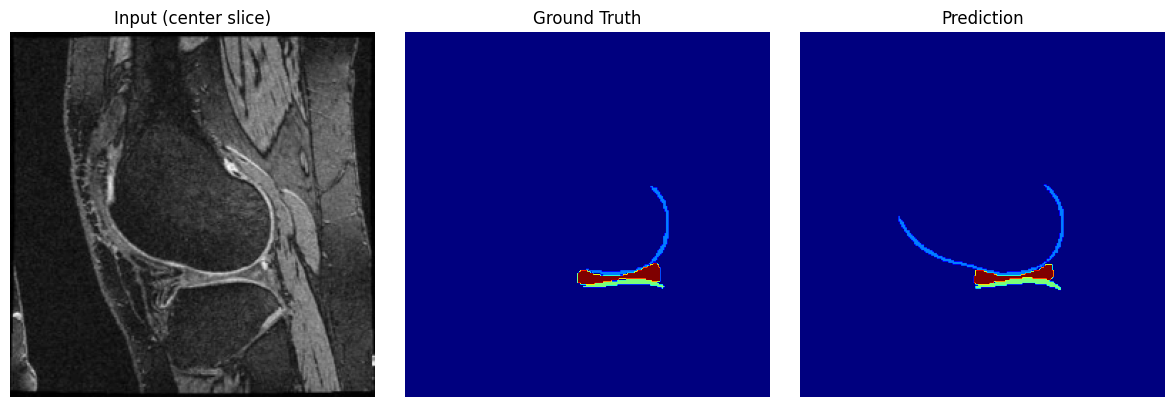

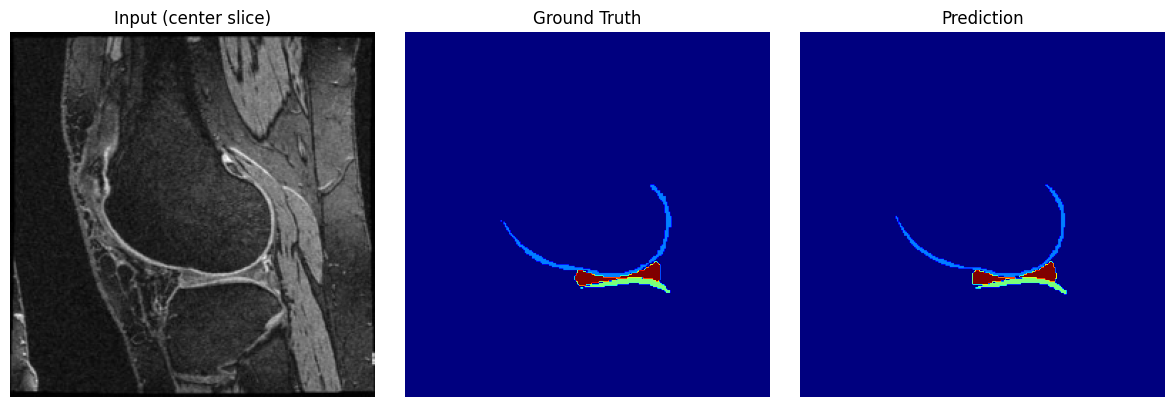

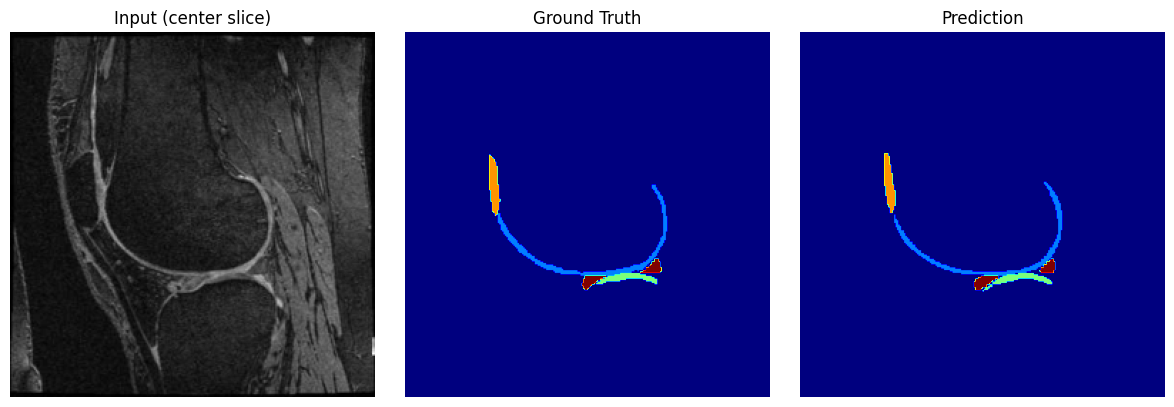

In [9]:
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# 5 random samples from val_loader
samples = list(val_loader)
images, masks = samples[0]  # batch of 8 by default
images = images[:5].to(device)  # take first 5
masks = masks[:5].to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1)  # [B, H, W]

# Plot
for i in range(5):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    true_mask = masks[i].cpu().numpy()
    pred_mask = preds[i].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img[:, :, 1], cmap='gray')  # center slice of 2.5D stack
    axs[0].set_title("Input (center slice)")
    axs[1].imshow(true_mask, cmap='jet', vmin=0, vmax=4)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=4)
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

torch.Size([256, 256])



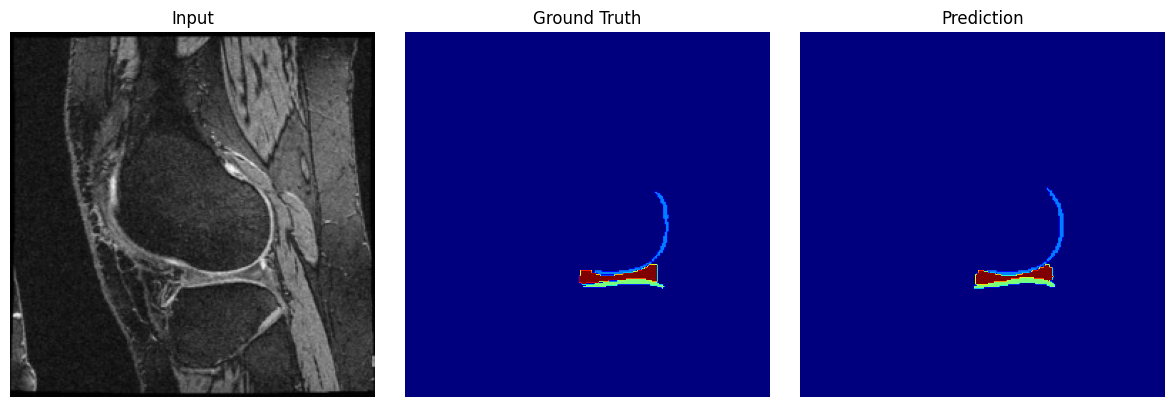

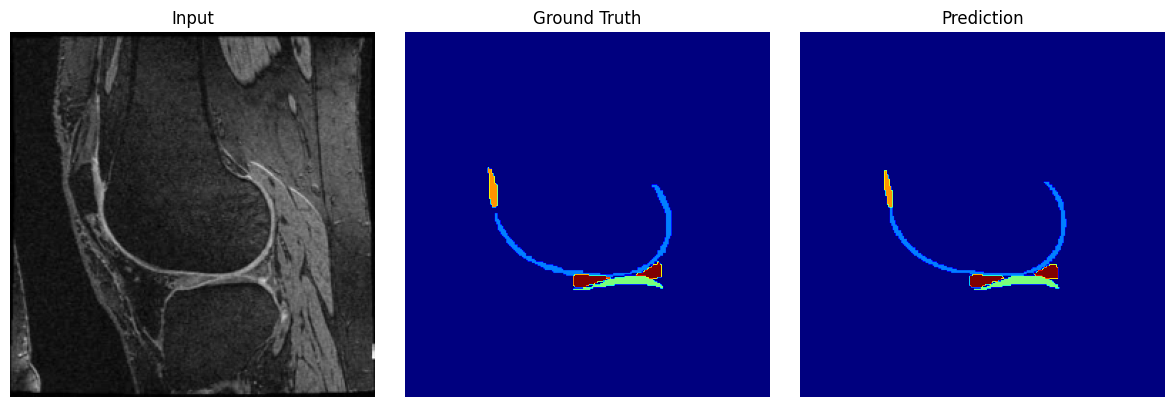

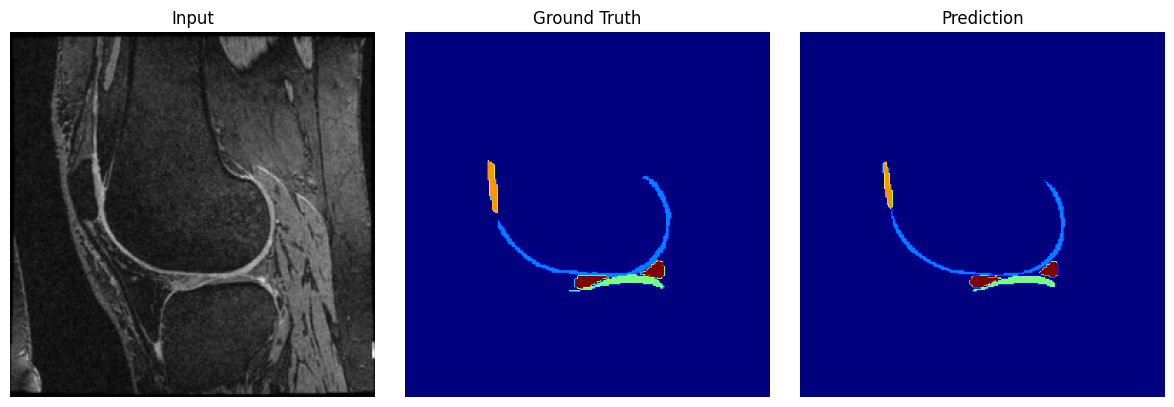

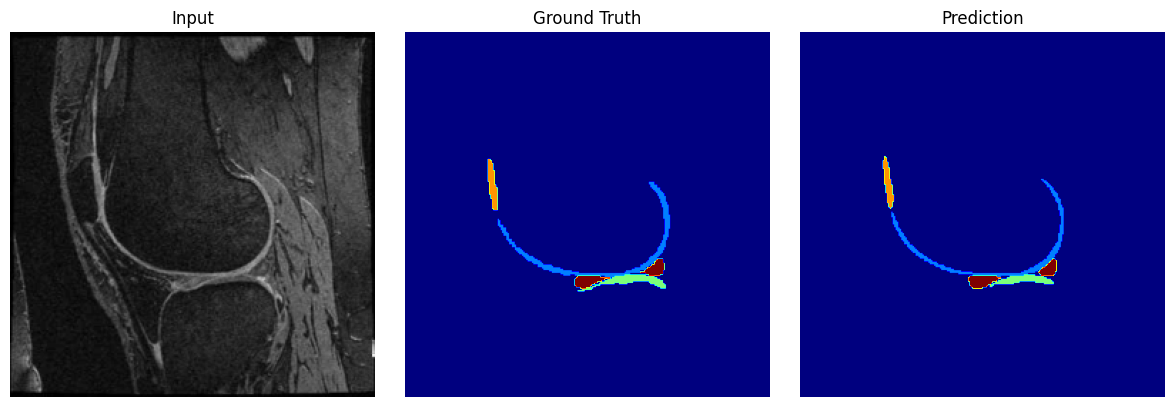

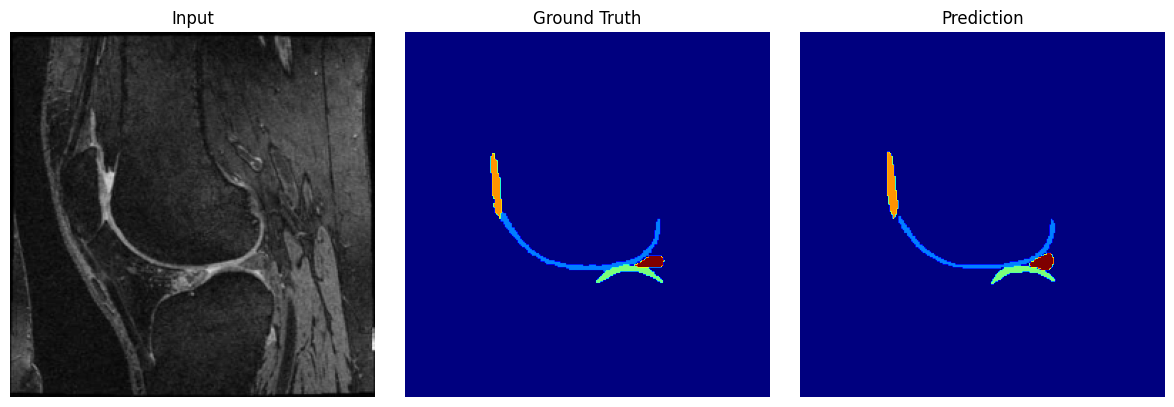

In [10]:
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# 5 random samples from test_loader
samples = list(test_loader)
images, masks = samples[0]  # batch of 8 by default
print(images[0][0].shape)
print()
images = images[:5].to(device)  # take first 5
masks = masks[:5].to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1)  

# Plot
for i in range(5):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    true_mask = masks[i].cpu().numpy()
    pred_mask = preds[i].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img[:, :, 1], cmap='gray')  # center slice of 2.5D stack
    axs[0].set_title("Input")
    axs[1].imshow(true_mask, cmap='jet', vmin=0, vmax=4)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=4)
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [33]:
true_mask = masks[1].cpu().numpy()
num_ge_1 = np.sum(true_mask >= 1)
num_eq_0 = np.sum(true_mask == 0)

print(f"Pixels with value >= 1: {num_ge_1}")
print(f"Pixels with value == 0: {num_eq_0}")

Pixels with value >= 1: 2850
Pixels with value == 0: 144606
